In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

Using TensorFlow backend.


### Data Info

The data is made up of 43 columns and 376,641 rows (first is the header).

Each row is a finished game of connect-4.

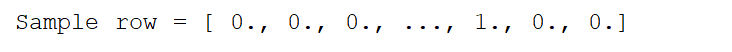

Columns 1-42 represent the positions on the board going from left to right, top to bottom.
Column 43 is the winner of the game

![game board data represantation](data_field_view.png)


Players are marked as 1 and -1, empty spaces or tie games are marked as 0.

![player values on field](data_sample.png)

## Read data

In [1]:
data = pd.read_csv(r'connect4data\c4_game_database.csv', sep=',', header=None, skiprows=[0])

print(data) 
data.shape

NameError: name 'pd' is not defined

## Data Cleaning
Remove faulty data, what shall be deleted?
(Hint: dataframe.dropna())

In [3]:
x1 ,y1 = data.shape
data = data.dropna(axis=0)
x2 ,y2 = data.shape
print("dropped {} rows with NaN values".format(x1-x2))

dropped 21 rows with NaN values


In [4]:
x1 ,y1 = data.shape
data = data.drop_duplicates()
x2 ,y2 = data.shape
print("delete {} duplicate rows".format(x1-x2))

delete 0 duplicate rows


## Extract the winner values (y_train)
Help for "Python Slice Notation": https://stackoverflow.com/a/509295/11341158

In [5]:
# extract winner from data 
winner = data.values[:, -1] # y_labels

# converts data to hot encoded array (keras needs this to classify, ML friendly format)
y_train = keras.utils.to_categorical(winner, num_classes=3) 
# [1 0 0] = tie (=0)
# [0 1 0] = bot loses  (=1)
# [0 0 1] = bot wins (=-1)
print(y_train)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


## Extract the training data (x_train)
Data without information about the winner (since we want to predict the winner)


Help for "Python Slice Notation": https://stackoverflow.com/a/509295/11341158

In [6]:
x_train = data.values[:,:-1]
print(x_train.shape)
x_train

(376619, 42)


array([[ 1.,  1.,  1., ..., -1.,  1., -1.],
       [ 0.,  0.,  1., ...,  1.,  1., -1.],
       [ 0.,  1.,  0., ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  1., ...,  1.,  1., -1.],
       [ 0.,  0.,  0., ...,  1., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1., -1.]])

## Data Normalization
Normalize your data as seen in the presentation

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train

array([[ 2.71113614e+00,  2.10046212e+00,  1.82010676e+00, ...,
        -1.02161653e+00,  1.07250685e+00, -1.13875637e+00],
       [ 2.81892403e-03,  2.40657003e-03,  1.82010676e+00, ...,
         1.02018528e+00,  1.07250685e+00, -1.13875637e+00],
       [ 2.81892403e-03,  2.10046212e+00, -5.80115248e-04, ...,
        -1.02161653e+00, -1.06943571e+00, -1.13875637e+00],
       ...,
       [ 2.81892403e-03,  2.40657003e-03,  1.82010676e+00, ...,
         1.02018528e+00,  1.07250685e+00, -1.13875637e+00],
       [ 2.81892403e-03,  2.40657003e-03, -5.80115248e-04, ...,
         1.02018528e+00, -1.06943571e+00,  3.24754245e-03],
       [ 2.81892403e-03,  2.40657003e-03, -5.80115248e-04, ...,
        -1.02161653e+00,  1.07250685e+00, -1.13875637e+00]])

## Train the model

### Add layers

``` python
# model.add(keras.layers.Dense("amount of neurons", activation="activation function"))
model.add(keras.layers.Dense(10, activation='relu'))
```

### Train your model
``` python 
#sample: history = model.fit(x_train, y_train, validation_split=0.20, epochs=100, batch_size=1000, shuffle=True)
history = model.fit(x_train, y_train, validation_split=0.20, epochs=???, batch_size=???, shuffle=True)
```

In [8]:
model = keras.Sequential()
model.add(keras.layers.Dense(42, activation='relu', input_shape=[42])) # 42 input features
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(15, activation='relu'))
model.add(keras.layers.Dense(15, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 3 different outcomes, [tie, lose, win]
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# validation split = % of data we use as test set
history = model.fit(x_train, y_train, validation_split=0.20, epochs=100, batch_size=1000, shuffle=True) 

Train on 301295 samples, validate on 75324 samples
Epoch 1/100
301295/301295 [==============================] - 2s 6us/step - loss: 0.9289 - acc: 0.4810 - val_loss: 0.8632 - val_acc: 0.4994
Epoch 2/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.8495 - acc: 0.5113 - val_loss: 0.8454 - val_acc: 0.5182
Epoch 3/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.8334 - acc: 0.5318 - val_loss: 0.8301 - val_acc: 0.5384
Epoch 4/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.8173 - acc: 0.5521 - val_loss: 0.8129 - val_acc: 0.5586
Epoch 5/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.7984 - acc: 0.5735 - val_loss: 0.7920 - val_acc: 0.5816
Epoch 6/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.7754 - acc: 0.5959 - val_loss: 0.7669 - val_acc: 0.6037
Epoch 7/100
301295/301295 [==============================] - 2s 5us/step - loss: 0.7493 - acc: 0.6177 - val_loss: 0

## Print history
Print the trainings history
Accuracy should be increasing and loss should be decreasing overtime

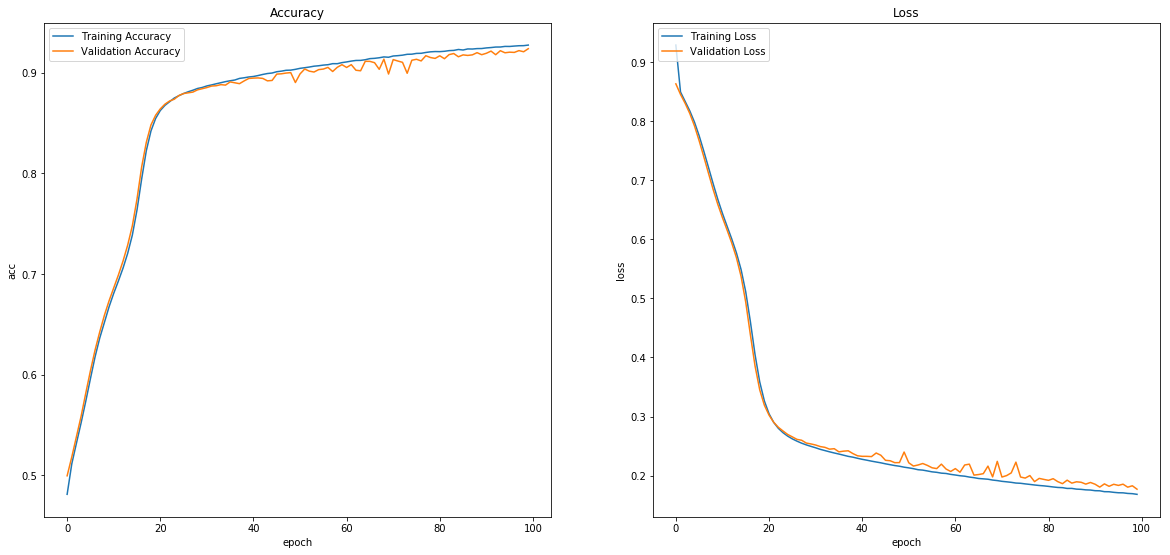

In [9]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

## Save the neural network to fileystem

In [10]:
# save the model weights
# H5 = Hierarchical Data Format
# https://en.wikipedia.org/wiki/Hierarchical_Data_Format
model.save("connect4predictor.H5")

In [11]:
mymodel = keras.models.load_model("connect4predictor.H5")

In [12]:
emptyfield = pd.DataFrame([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0,
  0.,  0.,  0.,  0.,  0.,  0.]])

In [13]:
empty_result = mymodel.predict(emptyfield.values)
print(empty_result)
print("predicted chance for tie:", empty_result[0,0]*100, "%")
print("predicted chance for loss:", empty_result[0,1]*100, "%")
print("predicted chance for win:", empty_result[0,2]*100, "%")
print("highest predicted chance was found at index", np.argmax(empty_result))

[[1.5198556e-07 6.8530333e-01 3.1469652e-01]]
predicted chance for tie: 1.5198556013729103e-05 %
predicted chance for loss: 68.53033304214478 %
predicted chance for win: 31.46965205669403 %
highest predicted chance was found at index 1


In [14]:
corners = pd.DataFrame([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
  0.,  0.,  0.,  0.,  0.,  1.]])
corners.shape

(1, 42)

In [15]:
corner_result = mymodel.predict(corners.values)
print(corner_result)
print("predicted chance for tie:", corner_result[0,0]*100, "%")
print("predicted chance for loss:", corner_result[0,1]*100, "%")
print("predicted chance for win:", corner_result[0,2]*100, "%")
print("highest predicted chance was found at index", np.argmax(corner_result))

[[1.0699428e-07 2.6515871e-01 7.3484123e-01]]
predicted chance for tie: 1.069942783260558e-05 %
predicted chance for loss: 26.515871286392212 %
predicted chance for win: 73.48412275314331 %
highest predicted chance was found at index 2


|Color|
|--- |
|Red|
|Green|
|Blue|

|Color|Price| 
|---|---| 
|Red|CHF 10000| 
|Red|CHF 20000| 
|Red|CHF 30000| 
|Green|CHF 10000| 
|Green|CHF 20000| 
|Green|CHF 30000| 
|Blue|CHF 10000| 
|Blue|CHF 20000| 
|Blue|CHF 30000|


|Color|Price|Year| 
|---|---|---| 
|Red|CHF 10000|2019 
|Red|CHF 10000|2018 
|Red|CHF 10000|2017
|Red|CHF 20000|2019
|Red|CHF 20000|2018 
|Red|CHF 20000|2017
|Red|CHF 30000|2019 
|Red|CHF 30000|2018 
|Red|CHF 30000|2017
|Green|CHF 10000|2019 
|Green|CHF 10000|2018 
|Green|CHF 10000|2017
|Green|CHF 20000|2019 
|Green|CHF 20000|2018 
|Green|CHF 20000|2017 
|Green|CHF 30000|2019 
|Green|CHF 30000|2018 
|Green|CHF 30000|2017 
|Blue|CHF 10000|2019 
|Blue|CHF 10000|2018 
|Blue|CHF 10000|2017 
|Blue|CHF 20000|2019 
|Blue|CHF 20000|2018 
|Blue|CHF 20000|2017 
|Blue|CHF 30000|2019
|Blue|CHF 30000|2018
|Blue|CHF 30000|2017

|Color|Weather|Price| 
|---|---|---| 
|Red|CHF 10000|Sunny|
|Green|CHF 20000|Rain|
|Blue|CHF 30000|Cloudy|